In [457]:
import pandas as pd
from pathlib import Path
import numpy as np
import datetime as dt
from pathlib import Path
import os
from datetime import datetime, timedelta

In [458]:
from sqlalchemy import create_engine

In [459]:
from collections import defaultdict

In [460]:
np.random.seed(42)

In [461]:
import matplotlib.pyplot as plt

In [462]:
engine = create_engine(
     "postgresql://pgadmin@fintech-postgres:CgYRz!)[4pfB@fintech-postgres.postgres.database.azure.com:5432/project01")

In [463]:
def get_portfolio_daily_returns(portfolio_name, *, covid_phase):
    '''
    portfolio_name := string,
    covid_phase := boolean (whether to include data including dates 2/19/20 - 4/29/20)
    
    Query the postgres db.
    Run basic calculations.
    
    Return DF of portfolio daily returns that will be used in the rest of the analysis.
    '''
    
    q = f'''
        select portfolio_name, weight, "date" as close_date, 
            close_price, ticker_name, covidineffect 
        from portfolio p
            inner join portfolio_tickers pt
            on p.portfolio_id = pt.portfolio_id
            inner join price
            on pt.ticker_id = price.ticker_id
        where price.covidineffect = {covid_phase} and p.portfolio_name = '{portfolio_name}'
        '''
    portfolio_df = pd.read_sql(q, engine)
    
    # Pivot the table so dates are index
    portfolio_df = portfolio_df.pivot(index='close_date', columns='ticker_name', values='close_price')
    
    daily_returns = portfolio_df.pct_change()
    
    daily_returns = daily_returns.dropna()
    
    return daily_returns

In [464]:
def portfolio_figures(pf_daily_returns):
    '''
    Returns tuple(last_close_price, returns_mean, returns_std)
    which can be passed in directly to `run_simulations`.
    '''
    return pf_daily_returns.iloc[-1], pf_daily_returns.mean(), pf_daily_returns.std()

In [465]:
def run_simulations(pf_figures, num_records, num_simulations):
    '''
    pf_data := tuple(last_close_prices, returns_means, returns_stds)
    
    Runs `num_simulations` Monte Carlo simulations each of `num_records`.
    
    Returns DF of cumulative returns
    '''
    
    monte_carlo_cum_returns_df = pd.DataFrame()
    
    last_close_prices, returns_means, returns_stds = pf_figures
    
    for m in range(num_simulations):
        simulated_prices_all = [[price] for price in last_close_prices]
        
        for _ in range(num_records):
            
            for i, prices in enumerate(simulated_prices_all):
                sim_price = prices[-1] * (1 + np.random.normal(returns_means[i], returns_stds[i]))
                prices.append(sim_price)

        monte_carlo_price_df = pd.DataFrame(dict(zip(last_close_prices.index, simulated_prices_all)))

        sim_daily_returns = monte_carlo_price_df.pct_change()

        weighted_returns = sim_daily_returns.dot([0.25] * 4)

        monte_carlo_cum_returns_df[m] = (1 + weighted_returns.fillna(0)).cumprod()
    
    return monte_carlo_cum_returns_df

In [466]:
# List of portfolios
portfolios = ['pharma', 'food', 'communication', 'hedge', 'financial']

# Dictionary for storing the results of the simulations
sim_results = dict.fromkeys(portfolios)

# Do the simulations and store results
for pf in portfolios:
    # covid=False here since we don't want data after 2/19/2020
    # Also notice the keyword `covid` is required here
    pf_returns = get_portfolio_daily_returns(pf, covid_phase=True)
    pf_figures = portfolio_figures(pf_returns)
    pf_sims = run_simulations(pf_figures, 63, 100) # 100 records, 100 simulation
    sim_results[pf] = pf_sims

In [467]:
hedge_results = sim_results['hedge']
hedge_results.tail()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
59,1.020843,1.033690,0.956007,1.191644,1.162697,1.119403,1.090556,1.007071,1.001874,1.048904,...,1.099019,0.947658,1.036066,1.054306,0.935576,1.131795,0.908796,0.986342,0.956481,0.960910
60,1.012107,1.054214,0.939060,1.179948,1.148904,1.146178,1.086872,0.998173,0.990509,1.059459,...,1.099386,0.960559,1.051328,1.056538,0.925554,1.154014,0.896038,0.980514,0.974151,0.960367
61,1.014062,1.060859,0.936470,1.194890,1.148849,1.144173,1.083993,0.985847,0.982789,1.051045,...,1.088113,0.953631,1.063561,1.044619,0.931407,1.171312,0.907308,0.994667,0.985457,0.957759
62,1.001315,1.043652,0.918224,1.205815,1.139230,1.149854,1.102648,0.983099,0.987884,1.054226,...,1.086703,0.954269,1.078827,1.042508,0.927335,1.174406,0.906526,0.978409,0.997270,0.951383
63,1.011210,1.054028,0.925226,1.221178,1.147823,1.151392,1.108501,0.978200,0.990470,1.039452,...,1.084545,0.942751,1.076400,1.060746,0.907827,1.184850,0.895623,0.965258,0.998406,0.942790


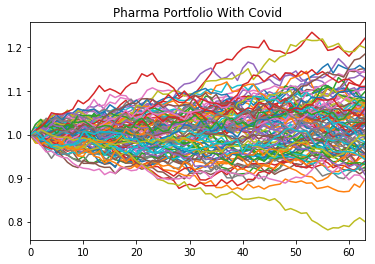

In [468]:
sim_results["hedge"].plot(legend=None, title= "Hedge Portfolio With Covid")

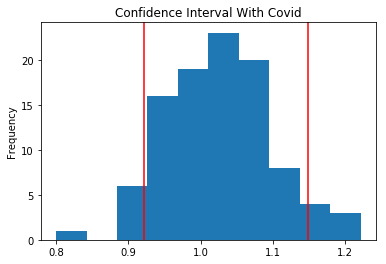

In [469]:
cumulative_returns = sim_results['hedge'].iloc[-1]
conf_interval= cumulative_returns.quantile(q=[0.05,0.95])
plt.figure()
cumulative_returns.plot(kind='hist', bins=10, title = "Confidence Interval With Covid")
plt.axvline(conf_interval.iloc[0], color='r')
plt.axvline(conf_interval.iloc[1], color='r')

In [470]:
initial_investment = 10000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = (initial_investment * (conf_interval.iloc[0]))
investment_pnl_upper_bound = (initial_investment * (conf_interval.iloc[1]))                                                

# Print the results
print(f"There is a 90% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 100 days will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 90% chance that an initial investment of $10,000 in the portfolio over the next 100 days will end within in the range of $9214.854469303693 and $11479.369640721678
